# База данных электрокардиограмм  для исследования аритмии

In [148]:
import sklearn
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

In [149]:
data = pd.read_csv("Diagnostics.csv",delimiter=';',index_col='FileName')
data 

,Rhythm,Beat,PatientAge,Gender,VentricularRate,AtrialRate,QRSDuration,QTInterval,QTCorrected,RAxis,TAxis,QRSCount,QOnset,QOffset,TOffset
FileName,,,,,,,,,,,,,,,
MUSE_20180113_171327_27000,AFIB,RBBB TWC,85,MALE,117,234,114,356,496,81,-27,19,208,265,386
MUSE_20180112_073319_29000,SB,TWC,59,FEMALE,52,52,92,432,401,76,42,8,215,261,431
MUSE_20180111_165520_97000,SA,NONE,20,FEMALE,67,67,82,382,403,88,20,11,224,265,415
MUSE_20180113_121940_44000,SB,NONE,66,MALE,53,53,96,456,427,34,3,9,219,267,447
MUSE_20180112_122850_57000,AF,STDD STTC,73,FEMALE,162,162,114,252,413,68,-40,26,228,285,354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MUSE_20181222_204306_99000,SVT,NONE,80,FEMALE,196,73,168,284,513,258,244,32,177,261,319
MUSE_20181222_204309_22000,SVT,NONE,81,FEMALE,162,81,162,294,482,110,-75,27,173,254,320
MUSE_20181222_204310_31000,SVT,NONE,39,MALE,152,92,152,340,540,250,38,25,208,284,378


### Label selection

Research labels:

Присутствует дисбаланс классов

In [150]:
data["Rhythm"].value_counts()

SB       3889
SR       1826
AFIB     1780
ST       1568
SVT       587
AF        445
SA        399
AT        121
AVNRT      16
AVRT        8
SAAWR       7
Name: Rhythm, dtype: int64

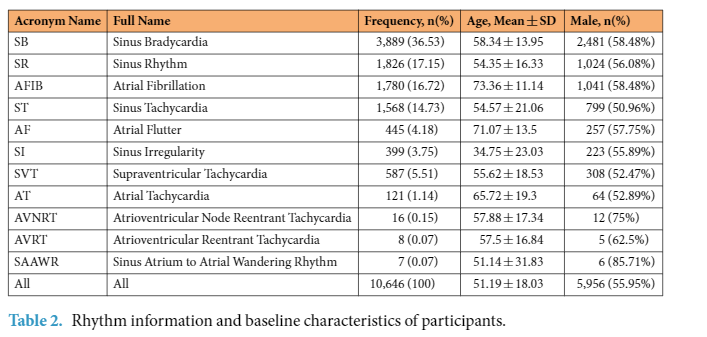

### Merge labels:

In [151]:
for i in range(0,len(data["Rhythm"])):
    if data['Rhythm'][i]=='AFIB' or data['Rhythm'][i]=='AF':
        data['Rhythm'][i]='AFIB'
    if data['Rhythm'][i]=='SVT' or data['Rhythm'][i]=='AT' or data['Rhythm'][i]=='AVNRT' or data['Rhythm'][i]=='AVRT'  or data['Rhythm'][i]=='ST' or data['Rhythm'][i]=='SAAWR':
        data['Rhythm'][i]='GSVT'
    if data['Rhythm'][i]=='SR' or data['Rhythm'][i]=='SA':
        data['Rhythm'][i]='SR'

In [152]:
data['Rhythm'].value_counts()

SB      3889
GSVT    2307
AFIB    2225
SR      2225
Name: Rhythm, dtype: int64

Поскольку некоторые редкие ритмы имеют менее 10 образцов, как показано в таблице 2, по предложению кардиологов мы иерархически объединили несколько редких случаев с типами аритмии верхнего уровня.  
Таким образом, 11 ритмов были объединены в 4 группы (SB, AFIB, GSVT, SR):

**SB включала:**  
1) синусовую брадикардию (sinus bradycardia)

**AFIB состояла:**  
1) фибрилляции предсердий (atrial fibrillation),  
2) трепетания предсердий (and atrial flutter (AF))  
  
**GSVT содержала:**  
1) Наджелудочковую тахикардию (supraventricular tachycardia),  
2) Предсердную тахикардию( atrial tachycardia),  
3) Атриовентрикулярную возвратная тахикардия в узле(atrioventricular node reentrant tachycardia),  
4) Возвратная атриовентрикулярная тахикардия(atrioventricular reentrant tachycardia),  
5) Синусовое предсердие с блуждающим ритмом предсердий(sinus atrium to atrial wandering rhythm),  
  
**SR включал:**  
1) синусовый ритм (sinus rhythm)  
2) нерегулярность синусового узла (sinus irregularity)

Без этого предположения максимальная точность (accuracy_score) достигает лишь 80%

## Correlated values

Проверим коррелирующие признаки

In [153]:
corr_mat = data.corr()
corr_mat

,PatientAge,VentricularRate,AtrialRate,QRSDuration,QTInterval,QTCorrected,RAxis,TAxis,QRSCount,QOnset,QOffset,TOffset
PatientAge,1.000000,0.032784,0.123134,0.095891,0.095131,0.240466,-0.253646,0.083759,0.031308,0.018093,0.114092,0.098501
VentricularRate,0.032784,1.000000,0.533340,-0.054847,-0.853169,0.421672,0.091437,0.104201,0.997072,0.011266,-0.048688,-0.846037
AtrialRate,0.123134,0.533340,1.000000,-0.060148,-0.474084,0.252017,0.051855,0.050377,0.530587,0.037640,-0.034009,-0.463366
QRSDuration,0.095891,-0.054847,-0.060148,1.000000,0.196121,0.188760,-0.084620,0.009285,-0.053868,-0.424377,0.719834,0.103680
QTInterval,0.095131,-0.853169,-0.474084,0.196121,1.000000,0.025108,-0.123269,-0.056627,-0.850519,-0.082541,0.141702,0.976715
QTCorrected,0.240466,0.421672,0.252017,0.188760,0.025108,1.000000,-0.048156,0.071952,0.420488,-0.125955,0.100727,-0.002145
RAxis,-0.253646,0.091437,0.051855,-0.084620,-0.123269,-0.048156,1.000000,0.046593,0.090857,0.061945,-0.040955,-0.109254
TAxis,0.083759,0.104201,0.050377,0.009285,-0.056627,0.071952,0.046593,1.000000,0.103753,-0.075576,-0.048233,-0.072584
QRSCount,0.031308,0.997072,0.530587,-0.053868,-0.850519,0.420488,0.090857,0.103753,1.000000,0.010224,-0.048463,-0.843626
QOnset,0.018093,0.011266,0.037640,-0.424377,-0.082541,-0.125955,0.061945,-0.075576,0.010224,1.000000,0.323058,0.133192


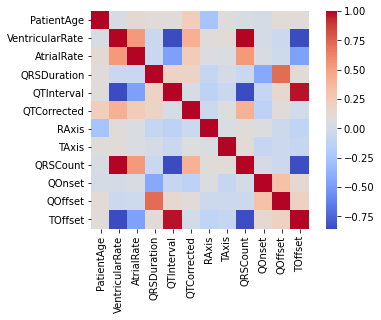

In [154]:
sns.heatmap(corr_mat, square=True, cmap='coolwarm')
pass

In [155]:
corr_mat.where(np.triu(corr_mat > 0.75, k=1)).stack().sort_values(ascending=False)

VentricularRate  QRSCount    0.997072
QTInterval       TOffset     0.976715
dtype: float64

In [156]:
data=data.drop(['TOffset'], axis = 1)
data=data.drop(['QRSCount'], axis = 1)

corr_mat = data.corr()
corr_mat.where(np.triu(corr_mat > 0.75, k=1)).stack().sort_values(ascending=False)


Series([], dtype: float64)

## Preproseccing data

### Label Encoder

In [157]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
data_notNull = data.drop(['Beat'], axis=1)
data_notNull

,Rhythm,PatientAge,Gender,VentricularRate,AtrialRate,QRSDuration,QTInterval,QTCorrected,RAxis,TAxis,QOnset,QOffset
FileName,,,,,,,,,,,,
MUSE_20180113_171327_27000,AFIB,85,MALE,117,234,114,356,496,81,-27,208,265
MUSE_20180112_073319_29000,SB,59,FEMALE,52,52,92,432,401,76,42,215,261
MUSE_20180111_165520_97000,SR,20,FEMALE,67,67,82,382,403,88,20,224,265
MUSE_20180113_121940_44000,SB,66,MALE,53,53,96,456,427,34,3,219,267
MUSE_20180112_122850_57000,AFIB,73,FEMALE,162,162,114,252,413,68,-40,228,285
...,...,...,...,...,...,...,...,...,...,...,...,...
MUSE_20181222_204306_99000,GSVT,80,FEMALE,196,73,168,284,513,258,244,177,261
MUSE_20181222_204309_22000,GSVT,81,FEMALE,162,81,162,294,482,110,-75,173,254
MUSE_20181222_204310_31000,GSVT,39,MALE,152,92,152,340,540,250,38,208,284


In [158]:
le.fit(data['Gender'])
data_notNull['Gender']=le.transform(data_notNull['Gender'])
le.fit(data_notNull['Rhythm'])
data_notNull['Rhythm']=le.transform(data_notNull['Rhythm'])
data_notNull=pd.get_dummies(data_notNull, columns=["Gender"])

In [159]:
data_notNull

,Rhythm,PatientAge,VentricularRate,AtrialRate,QRSDuration,QTInterval,QTCorrected,RAxis,TAxis,QOnset,QOffset,Gender_0,Gender_1
FileName,,,,,,,,,,,,,
MUSE_20180113_171327_27000,0,85,117,234,114,356,496,81,-27,208,265,0,1
MUSE_20180112_073319_29000,2,59,52,52,92,432,401,76,42,215,261,1,0
MUSE_20180111_165520_97000,3,20,67,67,82,382,403,88,20,224,265,1,0
MUSE_20180113_121940_44000,2,66,53,53,96,456,427,34,3,219,267,0,1
MUSE_20180112_122850_57000,0,73,162,162,114,252,413,68,-40,228,285,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
MUSE_20181222_204306_99000,1,80,196,73,168,284,513,258,244,177,261,1,0
MUSE_20181222_204309_22000,1,81,162,81,162,294,482,110,-75,173,254,1,0
MUSE_20181222_204310_31000,1,39,152,92,152,340,540,250,38,208,284,0,1


#  Vizualization


Проверим выбросы 

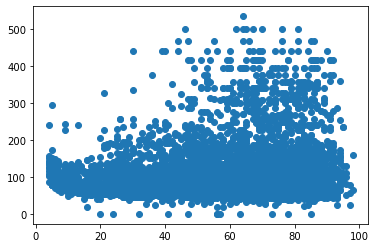

In [160]:
plt.scatter(data_notNull['PatientAge'],data_notNull['AtrialRate'])
pass

Для обнаружения выбросов найдем, например, квантили для признаков Rhythm и RAxis:

In [161]:
data_notNull['Rhythm'].quantile([0.005,.01,.05,.1,.5,.9,.95,.99,.995])

0.005    0.0
0.010    0.0
0.050    0.0
0.100    0.0
0.500    2.0
0.900    3.0
0.950    3.0
0.990    3.0
0.995    3.0
Name: Rhythm, dtype: float64

In [162]:
data_notNull['PatientAge'].quantile([0.005,.01,.05,.1,.5,.9,.95,.99,.995])

0.005     6.225
0.010     9.000
0.050    25.000
0.100    33.000
0.500    62.000
0.900    81.000
0.950    85.000
0.990    91.000
0.995    93.000
Name: PatientAge, dtype: float64

### Train/test separating

In [163]:
from sklearn.model_selection import StratifiedShuffleSplit
import imblearn

In [164]:
y=data_notNull['Rhythm']
data_notNull.pop('Rhythm')
X=data_notNull

In [165]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,stratify=y, random_state=42)

In [166]:
# from imblearn.under_sampling import NearMiss
# nm = NearMiss()
# X_train, y_train = nm.fit_resample(X_train, y_train.ravel())

In [167]:
print('После применения метода кол-во меток со значением True: {}'.format(sum(Y_train_miss == 2)))
print('После применения метода кол-во меток со значением True: {}'.format(sum(Y_train_miss == 1)))
print('После применения метода кол-во меток со значением True: {}'.format(sum(Y_train_miss == 3)))
print('После применения метода кол-во меток со значением True: {}'.format(sum(Y_train_miss == 0)))

После применения метода кол-во меток со значением True: 1669
После применения метода кол-во меток со значением True: 1669
После применения метода кол-во меток со значением True: 1669
После применения метода кол-во меток со значением True: 1669


In [168]:
y.value_counts()

2    3889
1    2307
3    2225
0    2225
Name: Rhythm, dtype: int64

4 итоговых класса

ML алгоритмы, которые требуют нормализации данных:  
Логистическая регрессия  
Метод опорных векторов  
Нейронная сеть  

(Метки нормализовать не надо)

In [169]:
from sklearn.preprocessing import scale
X_scaled=scale(X)
X_scaled


array([[ 1.43174458,  0.95385586,  2.35346148, ...,  0.02927467,
        -0.88737886,  0.88737886],
       [-0.01036269, -0.93273231, -0.67527234, ..., -0.44909542,
         1.12691439, -1.12691439],
       [-2.1735236 , -0.49736581, -0.42565142, ...,  0.02927467,
         1.12691439, -1.12691439],
       ...,
       [-1.11967598,  1.96971103, -0.00961656, ...,  2.30153259,
        -0.88737886,  0.88737886],
       [ 0.9325536 ,  2.637273  ,  1.42154338, ...,  0.50764476,
        -0.88737886,  0.88737886],
       [ 0.87708794,  0.95385586,  0.19008018, ...,  1.58397746,
        -0.88737886,  0.88737886]])

In [170]:
# X_train=scale(X_train)
# X_test=scale(X_test)

In [171]:
data_notNull

,PatientAge,VentricularRate,AtrialRate,QRSDuration,QTInterval,QTCorrected,RAxis,TAxis,QOnset,QOffset,Gender_0,Gender_1
FileName,,,,,,,,,,,,
MUSE_20180113_171327_27000,85,117,234,114,356,496,81,-27,208,265,0,1
MUSE_20180112_073319_29000,59,52,52,92,432,401,76,42,215,261,1,0
MUSE_20180111_165520_97000,20,67,67,82,382,403,88,20,224,265,1,0
MUSE_20180113_121940_44000,66,53,53,96,456,427,34,3,219,267,0,1
MUSE_20180112_122850_57000,73,162,162,114,252,413,68,-40,228,285,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
MUSE_20181222_204306_99000,80,196,73,168,284,513,258,244,177,261,1,0
MUSE_20181222_204309_22000,81,162,81,162,294,482,110,-75,173,254,1,0
MUSE_20181222_204310_31000,39,152,92,152,340,540,250,38,208,284,0,1


In [174]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,stratify=y, random_state=42)
#мое

In [175]:
X_train.shape

(7984, 12)

In [176]:
y_train.value_counts()

2    2916
1    1730
3    1669
0    1669
Name: Rhythm, dtype: int64

## Training and Evaluting Model 

In [194]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

### SVC

In [195]:
from sklearn.svm import SVC
clf = SVC()
clf.fit(X_train, y_train)

SVC()

In [196]:
y_pred=clf.predict(X_test)

print("recall test: ",recall_score(y_test.values, y_pred,average='macro'))
print("presion test: ",precision_score(y_test.values,y_pred ,average='macro'))
print("f1_score test: ",f1_score(y_test.values, y_pred,average='macro'))

recall test:  0.8190539051798917
presion test:  0.8363121861262433
f1_score test:  0.8212584077206749


In [197]:
confusion_matrix(y_test.values, y_pred)
conf_mx = confusion_matrix(y_test.values, y_pred) #посылаем предсказанные значения и истинные
conf_mx

array([[335, 127,  30,  64],
       [ 50, 518,   1,   8],
       [  0,   0, 972,   1],
       [ 25,  35,  64, 432]], dtype=int64)

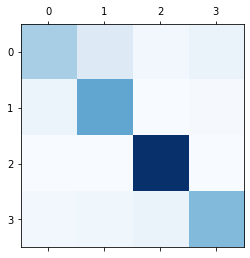

In [198]:
plt.matshow(conf_mx, cmap=plt.cm.Blues) 
plt.show() 

### KNN

In [199]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import ShuffleSplit
clf = KNeighborsClassifier()
cv = ShuffleSplit(n_splits=3, random_state=42)

clf.fit(X_train, y_train)

KNeighborsClassifier()

In [214]:
y_pred=clf.predict(X_test)

print("recall test: ",recall_score(y_test.values, y_pred,average='macro'))
print("presion test: ",precision_score(y_test.values,y_pred ,average='macro'))
print("f1_score test: ",f1_score(y_test.values, y_pred,average='macro'))

recall test:  0.9065271427324593
presion test:  0.9086353208837642
f1_score test:  0.9073623027346553


In [215]:
confusion_matrix(y_test.values, y_pred)
conf_mx = confusion_matrix(y_test.values, y_pred) 
conf_mx

array([[445,  73,  13,  25],
       [ 55, 511,   1,  10],
       [  1,   0, 969,   3],
       [ 23,   0,   8, 525]], dtype=int64)

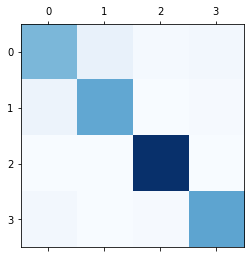

In [216]:
plt.matshow(conf_mx, cmap=plt.cm.Blues) 
plt.show() 

### RandomForest

In [217]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier()

In [218]:
y_pred=clf.predict(X_test)

print("recall test: ",recall_score(y_test.values, y_pred,average='macro'))
print("presion test: ",precision_score(y_test.values,y_pred ,average='macro'))
print("f1_score test: ",f1_score(y_test.values, y_pred,average='macro'))

recall test:  0.8970846966892938
presion test:  0.8988273207761122
f1_score test:  0.8977799860047511


In [219]:
confusion_matrix(y_test.values, y_pred)
conf_mx = confusion_matrix(y_test.values, y_pred) 
conf_mx

array([[436,  71,  12,  37],
       [ 55, 511,   1,  10],
       [  1,   0, 969,   3],
       [ 35,   0,   8, 513]], dtype=int64)

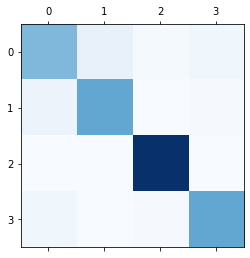

In [220]:
plt.matshow(conf_mx, cmap=plt.cm.Blues) 
plt.show() 

### GradientBoostingClassifier

In [221]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)

GradientBoostingClassifier()

In [222]:
y_pred=clf.predict(X_test)

print("recall test: ",recall_score(y_test.values, y_pred,average='macro'))
print("presion test: ",precision_score(y_test.values,y_pred ,average='macro'))
print("f1_score test: ",f1_score(y_test.values, y_pred,average='macro'))


recall test:  0.9065271427324593
presion test:  0.9086353208837642
f1_score test:  0.9073623027346553


In [223]:
confusion_matrix(y_test.values, y_pred)
conf_mx = confusion_matrix(y_test.values, y_pred)
conf_mx

array([[445,  73,  13,  25],
       [ 55, 511,   1,  10],
       [  1,   0, 969,   3],
       [ 23,   0,   8, 525]], dtype=int64)

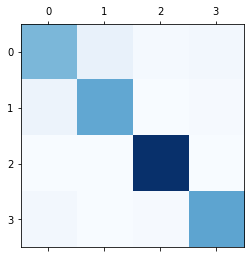

In [224]:
plt.matshow(conf_mx, cmap=plt.cm.Blues) 
plt.show() 